# Training the Language-Based Type Estimator

## Boilerplate

* For code change detection
* Seeing log messages inside the notebook
* Checking TensorFlow configuration.
* Setting random seeds

In [1]:
%load_ext autoreload
%autoreload 2

SEED: int = 42

import logging
logger: logging.Logger = logging.getLogger()
logger.setLevel(logging.INFO)

import tensorflow as tf
tf.random.set_seed(SEED)

import numpy as np
np.random.seed(SEED)

logging.info(f"Tensorflow version {tf.__version__}")
logging.info(f"Devices available: {tf.config.list_physical_devices()}")

logging.info("Starting analysis...")

2022-12-23 16:32:02.175600: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-12-23 16:32:02.255646: I tensorflow/core/util/port.cc:104] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2022-12-23 16:32:02.615682: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2022-12-23 16:32:02.615721: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] 

## Data Exploration

Checking label counts on the training dataset

<AxesSubplot: xlabel='will_help', ylabel='count'>

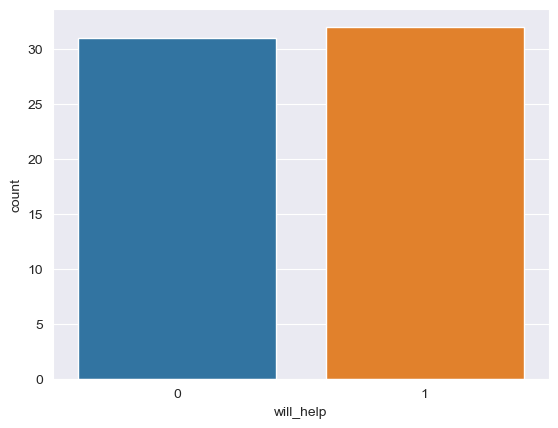

In [2]:
from sklearn.model_selection import train_test_split
import pandas as pd
import seaborn as sns

TRAINING_DATA_CSV_FILE = "data/training_data.csv"
training_dataset: pd.DataFrame = pd.read_csv(TRAINING_DATA_CSV_FILE)
validation_dataset: pd.DataFrame
training_dataset, validation_dataset = train_test_split(training_dataset, test_size=0.5)

sns.countplot(x="will_help", data=training_dataset)

## Sanity Checks

Let's train on a single sample, to verify data loading is working fine. We expect perfect accuracy after a few iterations.

In [3]:
from transformer_analyser import TransformerTypeAnalyser

type_analyser: TransformerTypeAnalyser = TransformerTypeAnalyser(epochs=5)
# type_analyser.train(training_dataset.head(1))

Instead of a single sample, we now train over a very small dataset. Again, we expect perfect accuracy after a few iterations.

In [4]:
small_sample: pd.DataFrame
_, small_sample = train_test_split(training_dataset, test_size=0.07, stratify=training_dataset["will_help"])

logging.info(small_sample["will_help"].value_counts())
type_analyser = TransformerTypeAnalyser(epochs=10)
# type_analyser.train(small_sample)


INFO:root:1    3
0    2
Name: will_help, dtype: int64


## Training the model
Training and validating with holdout data

In [5]:
type_analyser = TransformerTypeAnalyser(epochs=15, batch_size=8, learning_rate=3e-5)
type_analyser.train(training_data=training_dataset, testing_data=validation_dataset)


INFO:root:Starting training...
2022-12-23 16:32:04.192065: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-12-23 16:32:04.193725: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-23 16:32:04.194123: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-23 16:32:04.194337: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had

Keras weights file (<HDF5 file "variables.h5" (mode r+)>) saving:
...bert
......embeddings
.........LayerNorm
............vars
...............0
...............1
.........dropout
............vars
.........vars
............0
............1
............2
......encoder
.........layer
............tf_bert_layer
...............attention
..................dense_output
.....................LayerNorm
........................vars
...........................0
...........................1
.....................dense
........................vars
...........................0
...........................1
.....................dropout
........................vars
.....................vars
..................self_attention
.....................dropout
........................vars
.....................key
........................vars
...........................0
...........................1
.....................query
........................vars
...........................0
...........................1
.....

  0%|          | 0/1 [00:00<?, ?ba/s]

Keras weights file (<HDF5 file "variables.h5" (mode r+)>) saving:
...bert
......embeddings
.........LayerNorm
............vars
...............0
...............1
.........dropout
............vars
.........vars
............0
............1
............2
......encoder
.........layer
............tf_bert_layer
...............attention
..................dense_output
.....................LayerNorm
........................vars
...........................0
...........................1
.....................dense
........................vars
...........................0
...........................1
.....................dropout
........................vars
.....................vars
..................self_attention
.....................dropout
........................vars
.....................key
........................vars
...........................0
...........................1
.....................query
........................vars
...........................0
...........................1
.....

  0%|          | 0/1 [00:00<?, ?ba/s]

INFO:root:Encoding finished. Starting training


Epoch 1/15


2022-12-23 16:32:22.565741: I tensorflow/compiler/xla/service/service.cc:173] XLA service 0x7fb78003ca90 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2022-12-23 16:32:22.565759: I tensorflow/compiler/xla/service/service.cc:181]   StreamExecutor device (0): NVIDIA RTX A5000 Laptop GPU, Compute Capability 8.6
2022-12-23 16:32:22.568983: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2022-12-23 16:32:22.617559: W tensorflow/compiler/xla/stream_executor/gpu/asm_compiler.cc:115] *** WARNING *** You are using ptxas 10.1.243, which is older than 11.1. ptxas before 11.1 is known to miscompile XLA code, leading to incorrect results or invalid-address errors.

You may not need to update to CUDA 11.1; cherry-picking the ptxas binary is often sufficient.
2022-12-23 16:32:22.618486: W tensorflow/compiler/xla/stream_executor/gpu/asm_compiler.cc:234]

2/8 [======>.......................] - ETA: 2s - loss: 0.7753 - sparse_categorical_accuracy: 0.3750  

2022-12-23 16:32:32.780179: W tensorflow/compiler/xla/stream_executor/gpu/asm_compiler.cc:115] *** WARNING *** You are using ptxas 10.1.243, which is older than 11.1. ptxas before 11.1 is known to miscompile XLA code, leading to incorrect results or invalid-address errors.

You may not need to update to CUDA 11.1; cherry-picking the ptxas binary is often sufficient.


3/8 [==========>...................] - ETA: 1s - loss: 0.7392 - sparse_categorical_accuracy: 0.5000

2022-12-23 16:32:33.110365: W tensorflow/compiler/xla/stream_executor/gpu/asm_compiler.cc:115] *** WARNING *** You are using ptxas 10.1.243, which is older than 11.1. ptxas before 11.1 is known to miscompile XLA code, leading to incorrect results or invalid-address errors.

You may not need to update to CUDA 11.1; cherry-picking the ptxas binary is often sufficient.


4/8 [==============>...............] - ETA: 1s - loss: 0.7149 - sparse_categorical_accuracy: 0.5312

2022-12-23 16:32:33.448183: W tensorflow/compiler/xla/stream_executor/gpu/asm_compiler.cc:115] *** WARNING *** You are using ptxas 10.1.243, which is older than 11.1. ptxas before 11.1 is known to miscompile XLA code, leading to incorrect results or invalid-address errors.

You may not need to update to CUDA 11.1; cherry-picking the ptxas binary is often sufficient.


5/8 [=================>............] - ETA: 1s - loss: 0.7073 - sparse_categorical_accuracy: 0.5500

2022-12-23 16:32:33.783754: W tensorflow/compiler/xla/stream_executor/gpu/asm_compiler.cc:115] *** WARNING *** You are using ptxas 10.1.243, which is older than 11.1. ptxas before 11.1 is known to miscompile XLA code, leading to incorrect results or invalid-address errors.

You may not need to update to CUDA 11.1; cherry-picking the ptxas binary is often sufficient.


6/8 [=====================>........] - ETA: 0s - loss: 0.7039 - sparse_categorical_accuracy: 0.5417

2022-12-23 16:32:34.115414: W tensorflow/compiler/xla/stream_executor/gpu/asm_compiler.cc:115] *** WARNING *** You are using ptxas 10.1.243, which is older than 11.1. ptxas before 11.1 is known to miscompile XLA code, leading to incorrect results or invalid-address errors.

You may not need to update to CUDA 11.1; cherry-picking the ptxas binary is often sufficient.


8/8 [==============================] - ETA: 0s - loss: 0.6971 - sparse_categorical_accuracy: 0.5556

2022-12-23 16:32:34.761994: W tensorflow/compiler/xla/stream_executor/gpu/asm_compiler.cc:115] *** WARNING *** You are using ptxas 10.1.243, which is older than 11.1. ptxas before 11.1 is known to miscompile XLA code, leading to incorrect results or invalid-address errors.

You may not need to update to CUDA 11.1; cherry-picking the ptxas binary is often sufficient.


8/8 [==============================] - 29s 773ms/step - loss: 0.6971 - sparse_categorical_accuracy: 0.5556 - val_loss: 0.6490 - val_sparse_categorical_accuracy: 0.7619
Epoch 2/15
1/8 [==>...........................] - ETA: 2s - loss: 0.5967 - sparse_categorical_accuracy: 0.8750

2022-12-23 16:32:38.191522: W tensorflow/compiler/xla/stream_executor/gpu/asm_compiler.cc:115] *** WARNING *** You are using ptxas 10.1.243, which is older than 11.1. ptxas before 11.1 is known to miscompile XLA code, leading to incorrect results or invalid-address errors.

You may not need to update to CUDA 11.1; cherry-picking the ptxas binary is often sufficient.


4/8 [==============>...............] - ETA: 1s - loss: 0.5922 - sparse_categorical_accuracy: 0.8438

2022-12-23 16:32:39.193097: W tensorflow/compiler/xla/stream_executor/gpu/asm_compiler.cc:115] *** WARNING *** You are using ptxas 10.1.243, which is older than 11.1. ptxas before 11.1 is known to miscompile XLA code, leading to incorrect results or invalid-address errors.

You may not need to update to CUDA 11.1; cherry-picking the ptxas binary is often sufficient.


6/8 [=====================>........] - ETA: 0s - loss: 0.5590 - sparse_categorical_accuracy: 0.8958

2022-12-23 16:32:39.856729: W tensorflow/compiler/xla/stream_executor/gpu/asm_compiler.cc:115] *** WARNING *** You are using ptxas 10.1.243, which is older than 11.1. ptxas before 11.1 is known to miscompile XLA code, leading to incorrect results or invalid-address errors.

You may not need to update to CUDA 11.1; cherry-picking the ptxas binary is often sufficient.


7/8 [=========================>....] - ETA: 0s - loss: 0.5595 - sparse_categorical_accuracy: 0.8929

2022-12-23 16:32:40.196019: W tensorflow/compiler/xla/stream_executor/gpu/asm_compiler.cc:115] *** WARNING *** You are using ptxas 10.1.243, which is older than 11.1. ptxas before 11.1 is known to miscompile XLA code, leading to incorrect results or invalid-address errors.

You may not need to update to CUDA 11.1; cherry-picking the ptxas binary is often sufficient.


8/8 [==============================] - 4s 475ms/step - loss: 0.5688 - sparse_categorical_accuracy: 0.8571 - val_loss: 0.5506 - val_sparse_categorical_accuracy: 0.8254
Epoch 3/15
1/8 [==>...........................] - ETA: 2s - loss: 0.3969 - sparse_categorical_accuracy: 1.0000

2022-12-23 16:32:41.853957: W tensorflow/compiler/xla/stream_executor/gpu/asm_compiler.cc:115] *** WARNING *** You are using ptxas 10.1.243, which is older than 11.1. ptxas before 11.1 is known to miscompile XLA code, leading to incorrect results or invalid-address errors.

You may not need to update to CUDA 11.1; cherry-picking the ptxas binary is often sufficient.


3/8 [==========>...................] - ETA: 1s - loss: 0.4172 - sparse_categorical_accuracy: 1.0000

2022-12-23 16:32:42.517433: W tensorflow/compiler/xla/stream_executor/gpu/asm_compiler.cc:115] *** WARNING *** You are using ptxas 10.1.243, which is older than 11.1. ptxas before 11.1 is known to miscompile XLA code, leading to incorrect results or invalid-address errors.

You may not need to update to CUDA 11.1; cherry-picking the ptxas binary is often sufficient.


4/8 [==============>...............] - ETA: 1s - loss: 0.4028 - sparse_categorical_accuracy: 1.0000

2022-12-23 16:32:42.854882: W tensorflow/compiler/xla/stream_executor/gpu/asm_compiler.cc:115] *** WARNING *** You are using ptxas 10.1.243, which is older than 11.1. ptxas before 11.1 is known to miscompile XLA code, leading to incorrect results or invalid-address errors.

You may not need to update to CUDA 11.1; cherry-picking the ptxas binary is often sufficient.


5/8 [=================>............] - ETA: 1s - loss: 0.3952 - sparse_categorical_accuracy: 1.0000

2022-12-23 16:32:43.191402: W tensorflow/compiler/xla/stream_executor/gpu/asm_compiler.cc:115] *** WARNING *** You are using ptxas 10.1.243, which is older than 11.1. ptxas before 11.1 is known to miscompile XLA code, leading to incorrect results or invalid-address errors.

You may not need to update to CUDA 11.1; cherry-picking the ptxas binary is often sufficient.


7/8 [=========================>....] - ETA: 0s - loss: 0.3811 - sparse_categorical_accuracy: 0.9821

2022-12-23 16:32:43.860332: W tensorflow/compiler/xla/stream_executor/gpu/asm_compiler.cc:115] *** WARNING *** You are using ptxas 10.1.243, which is older than 11.1. ptxas before 11.1 is known to miscompile XLA code, leading to incorrect results or invalid-address errors.

You may not need to update to CUDA 11.1; cherry-picking the ptxas binary is often sufficient.


8/8 [==============================] - 4s 474ms/step - loss: 0.3833 - sparse_categorical_accuracy: 0.9683 - val_loss: 0.4191 - val_sparse_categorical_accuracy: 0.8889
Epoch 4/15
1/8 [==>...........................] - ETA: 2s - loss: 0.2320 - sparse_categorical_accuracy: 1.0000

2022-12-23 16:32:45.515025: W tensorflow/compiler/xla/stream_executor/gpu/asm_compiler.cc:115] *** WARNING *** You are using ptxas 10.1.243, which is older than 11.1. ptxas before 11.1 is known to miscompile XLA code, leading to incorrect results or invalid-address errors.

You may not need to update to CUDA 11.1; cherry-picking the ptxas binary is often sufficient.


3/8 [==========>...................] - ETA: 1s - loss: 0.2710 - sparse_categorical_accuracy: 0.9583

2022-12-23 16:32:46.178863: W tensorflow/compiler/xla/stream_executor/gpu/asm_compiler.cc:115] *** WARNING *** You are using ptxas 10.1.243, which is older than 11.1. ptxas before 11.1 is known to miscompile XLA code, leading to incorrect results or invalid-address errors.

You may not need to update to CUDA 11.1; cherry-picking the ptxas binary is often sufficient.


5/8 [=================>............] - ETA: 1s - loss: 0.2397 - sparse_categorical_accuracy: 0.9750

2022-12-23 16:32:46.850188: W tensorflow/compiler/xla/stream_executor/gpu/asm_compiler.cc:115] *** WARNING *** You are using ptxas 10.1.243, which is older than 11.1. ptxas before 11.1 is known to miscompile XLA code, leading to incorrect results or invalid-address errors.

You may not need to update to CUDA 11.1; cherry-picking the ptxas binary is often sufficient.


8/8 [==============================] - 4s 459ms/step - loss: 0.2215 - sparse_categorical_accuracy: 0.9683 - val_loss: 0.4435 - val_sparse_categorical_accuracy: 0.7778
Epoch 5/15
1/8 [==>...........................] - ETA: 2s - loss: 0.0998 - sparse_categorical_accuracy: 1.0000

2022-12-23 16:32:49.059429: W tensorflow/compiler/xla/stream_executor/gpu/asm_compiler.cc:115] *** WARNING *** You are using ptxas 10.1.243, which is older than 11.1. ptxas before 11.1 is known to miscompile XLA code, leading to incorrect results or invalid-address errors.

You may not need to update to CUDA 11.1; cherry-picking the ptxas binary is often sufficient.


6/8 [=====================>........] - ETA: 0s - loss: 0.1558 - sparse_categorical_accuracy: 0.9375

2022-12-23 16:32:50.726025: W tensorflow/compiler/xla/stream_executor/gpu/asm_compiler.cc:115] *** WARNING *** You are using ptxas 10.1.243, which is older than 11.1. ptxas before 11.1 is known to miscompile XLA code, leading to incorrect results or invalid-address errors.

You may not need to update to CUDA 11.1; cherry-picking the ptxas binary is often sufficient.


7/8 [=========================>....] - ETA: 0s - loss: 0.1459 - sparse_categorical_accuracy: 0.9464

2022-12-23 16:32:51.062909: W tensorflow/compiler/xla/stream_executor/gpu/asm_compiler.cc:115] *** WARNING *** You are using ptxas 10.1.243, which is older than 11.1. ptxas before 11.1 is known to miscompile XLA code, leading to incorrect results or invalid-address errors.

You may not need to update to CUDA 11.1; cherry-picking the ptxas binary is often sufficient.


8/8 [==============================] - 4s 473ms/step - loss: 0.1392 - sparse_categorical_accuracy: 0.9524 - val_loss: 0.3141 - val_sparse_categorical_accuracy: 0.8730
Epoch 6/15
2/8 [======>.......................] - ETA: 2s - loss: 0.0609 - sparse_categorical_accuracy: 1.0000

2022-12-23 16:32:53.040622: W tensorflow/compiler/xla/stream_executor/gpu/asm_compiler.cc:115] *** WARNING *** You are using ptxas 10.1.243, which is older than 11.1. ptxas before 11.1 is known to miscompile XLA code, leading to incorrect results or invalid-address errors.

You may not need to update to CUDA 11.1; cherry-picking the ptxas binary is often sufficient.


3/8 [==========>...................] - ETA: 1s - loss: 0.0711 - sparse_categorical_accuracy: 1.0000

2022-12-23 16:32:53.381484: W tensorflow/compiler/xla/stream_executor/gpu/asm_compiler.cc:115] *** WARNING *** You are using ptxas 10.1.243, which is older than 11.1. ptxas before 11.1 is known to miscompile XLA code, leading to incorrect results or invalid-address errors.

You may not need to update to CUDA 11.1; cherry-picking the ptxas binary is often sufficient.


4/8 [==============>...............] - ETA: 1s - loss: 0.0658 - sparse_categorical_accuracy: 1.0000

2022-12-23 16:32:53.716792: W tensorflow/compiler/xla/stream_executor/gpu/asm_compiler.cc:115] *** WARNING *** You are using ptxas 10.1.243, which is older than 11.1. ptxas before 11.1 is known to miscompile XLA code, leading to incorrect results or invalid-address errors.

You may not need to update to CUDA 11.1; cherry-picking the ptxas binary is often sufficient.


5/8 [=================>............] - ETA: 1s - loss: 0.0779 - sparse_categorical_accuracy: 1.0000

2022-12-23 16:32:54.049417: W tensorflow/compiler/xla/stream_executor/gpu/asm_compiler.cc:115] *** WARNING *** You are using ptxas 10.1.243, which is older than 11.1. ptxas before 11.1 is known to miscompile XLA code, leading to incorrect results or invalid-address errors.

You may not need to update to CUDA 11.1; cherry-picking the ptxas binary is often sufficient.


7/8 [=========================>....] - ETA: 0s - loss: 0.0674 - sparse_categorical_accuracy: 1.0000

2022-12-23 16:32:54.722110: W tensorflow/compiler/xla/stream_executor/gpu/asm_compiler.cc:115] *** WARNING *** You are using ptxas 10.1.243, which is older than 11.1. ptxas before 11.1 is known to miscompile XLA code, leading to incorrect results or invalid-address errors.

You may not need to update to CUDA 11.1; cherry-picking the ptxas binary is often sufficient.


8/8 [==============================] - 4s 475ms/step - loss: 0.0648 - sparse_categorical_accuracy: 1.0000 - val_loss: 0.2959 - val_sparse_categorical_accuracy: 0.8889
Epoch 7/15
5/8 [=================>............] - ETA: 1s - loss: 0.0316 - sparse_categorical_accuracy: 1.0000

2022-12-23 16:32:57.700562: W tensorflow/compiler/xla/stream_executor/gpu/asm_compiler.cc:115] *** WARNING *** You are using ptxas 10.1.243, which is older than 11.1. ptxas before 11.1 is known to miscompile XLA code, leading to incorrect results or invalid-address errors.

You may not need to update to CUDA 11.1; cherry-picking the ptxas binary is often sufficient.


8/8 [==============================] - 4s 460ms/step - loss: 0.0285 - sparse_categorical_accuracy: 1.0000 - val_loss: 0.3365 - val_sparse_categorical_accuracy: 0.8889
Epoch 8/15
8/8 [==============================] - ETA: 0s - loss: 0.0168 - sparse_categorical_accuracy: 1.0000

2022-12-23 16:33:02.242371: W tensorflow/compiler/xla/stream_executor/gpu/asm_compiler.cc:115] *** WARNING *** You are using ptxas 10.1.243, which is older than 11.1. ptxas before 11.1 is known to miscompile XLA code, leading to incorrect results or invalid-address errors.

You may not need to update to CUDA 11.1; cherry-picking the ptxas binary is often sufficient.


8/8 [==============================] - 4s 461ms/step - loss: 0.0168 - sparse_categorical_accuracy: 1.0000 - val_loss: 0.3672 - val_sparse_categorical_accuracy: 0.8730
Epoch 9/15
8/8 [==============================] - 4s 461ms/step - loss: 0.0107 - sparse_categorical_accuracy: 1.0000 - val_loss: 0.3823 - val_sparse_categorical_accuracy: 0.8730
Epoch 10/15
4/8 [==============>...............] - ETA: 1s - loss: 0.0094 - sparse_categorical_accuracy: 1.0000

2022-12-23 16:33:08.054822: W tensorflow/compiler/xla/stream_executor/gpu/asm_compiler.cc:115] *** WARNING *** You are using ptxas 10.1.243, which is older than 11.1. ptxas before 11.1 is known to miscompile XLA code, leading to incorrect results or invalid-address errors.

You may not need to update to CUDA 11.1; cherry-picking the ptxas binary is often sufficient.


5/8 [=================>............] - ETA: 1s - loss: 0.0092 - sparse_categorical_accuracy: 1.0000

2022-12-23 16:33:08.393192: W tensorflow/compiler/xla/stream_executor/gpu/asm_compiler.cc:115] *** WARNING *** You are using ptxas 10.1.243, which is older than 11.1. ptxas before 11.1 is known to miscompile XLA code, leading to incorrect results or invalid-address errors.

You may not need to update to CUDA 11.1; cherry-picking the ptxas binary is often sufficient.


8/8 [==============================] - ETA: 0s - loss: 0.0088 - sparse_categorical_accuracy: 1.0000

2022-12-23 16:33:09.381030: W tensorflow/compiler/xla/stream_executor/gpu/asm_compiler.cc:115] *** WARNING *** You are using ptxas 10.1.243, which is older than 11.1. ptxas before 11.1 is known to miscompile XLA code, leading to incorrect results or invalid-address errors.

You may not need to update to CUDA 11.1; cherry-picking the ptxas binary is often sufficient.


8/8 [==============================] - 4s 463ms/step - loss: 0.0088 - sparse_categorical_accuracy: 1.0000 - val_loss: 0.3963 - val_sparse_categorical_accuracy: 0.8730
Epoch 11/15
1/8 [==>...........................] - ETA: 2s - loss: 0.0072 - sparse_categorical_accuracy: 1.0000

2022-12-23 16:33:10.623768: W tensorflow/compiler/xla/stream_executor/gpu/asm_compiler.cc:115] *** WARNING *** You are using ptxas 10.1.243, which is older than 11.1. ptxas before 11.1 is known to miscompile XLA code, leading to incorrect results or invalid-address errors.

You may not need to update to CUDA 11.1; cherry-picking the ptxas binary is often sufficient.


5/8 [=================>............] - ETA: 1s - loss: 0.0065 - sparse_categorical_accuracy: 1.0000

2022-12-23 16:33:11.970793: W tensorflow/compiler/xla/stream_executor/gpu/asm_compiler.cc:115] *** WARNING *** You are using ptxas 10.1.243, which is older than 11.1. ptxas before 11.1 is known to miscompile XLA code, leading to incorrect results or invalid-address errors.

You may not need to update to CUDA 11.1; cherry-picking the ptxas binary is often sufficient.


6/8 [=====================>........] - ETA: 0s - loss: 0.0065 - sparse_categorical_accuracy: 1.0000

2022-12-23 16:33:12.306355: W tensorflow/compiler/xla/stream_executor/gpu/asm_compiler.cc:115] *** WARNING *** You are using ptxas 10.1.243, which is older than 11.1. ptxas before 11.1 is known to miscompile XLA code, leading to incorrect results or invalid-address errors.

You may not need to update to CUDA 11.1; cherry-picking the ptxas binary is often sufficient.


8/8 [==============================] - 4s 477ms/step - loss: 0.0063 - sparse_categorical_accuracy: 1.0000 - val_loss: 0.4118 - val_sparse_categorical_accuracy: 0.8730
Epoch 11: early stopping


INFO:root:Model and Tokenizer saved at ./model
